# Import

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Метод Якоби

In [2]:
def jacobi_method(A, b, x0=None, eps=1e-8, max_iter=1000, divergence_threshold=1e8):
    n = len(b)
    
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0.copy()
    
    # Предварительное вычисление диагональных элементов
    # Добавляем небольшую константу для предотвращения деления на 0
    D_inv = np.diag(1.0 / (np.diag(A) + 1e-12))
    R = A - np.diag(np.diag(A))  # Матрица без диагонали
    
    iterations = 0
    residual = np.inf
    
    for k in range(max_iter):
        iterations = k + 1
        
        try:
            x_new = D_inv @ (b - R @ x)
            
            # Проверка на расходимость
            if (np.any(np.isnan(x_new)) or np.any(np.isinf(x_new)) or 
                np.linalg.norm(x_new) > divergence_threshold):
                raise RuntimeError("Метод расходится")
            
            # Критерий остановки по норме разности приближений
            if np.linalg.norm(x_new - x) < eps:
                x = x_new
                residual = np.linalg.norm(A @ x - b)
                if residual < eps:
                    return x, iterations, residual
            elif k > 0 and np.linalg.norm(x_new - x) > np.linalg.norm(x - x_old):
                # Если разность увеличивается, метод может расходиться
                raise RuntimeError("Метод расходится")
            
            x_old = x.copy()
            x = x_new.copy()
            
        except RuntimeError as e:
            residual = np.linalg.norm(A @ x - b)
            print(f"  Предупреждение: {e} на итерации {iterations}")
            return x, iterations, residual
        except Exception as e:
            print(f"  Ошибка: {e}")
            residual = np.linalg.norm(A @ x - b)
            return x, iterations, residual
    
    residual = np.linalg.norm(A @ x - b)
    if residual > eps:
        print(f"  Предупреждение: метод не достиг требуемой точности за {max_iter} итераций")
    
    return x, iterations, residual

# Метод минимальных невязок

In [3]:
def min_residual_method(A, b, x0=None, eps=1e-8, max_iter=1000):
    n = len(b)
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0.copy()
    
    for k in range(max_iter):
        r = A @ x - b
        res_norm = np.linalg.norm(r)
        
        if res_norm < eps:
            break
            
        Ar = A @ r
        numerator = np.dot(r, Ar)
        denominator = np.dot(Ar, Ar)
        
        if abs(denominator) < 1e-14:
            break
            
        alpha = numerator / denominator
        x = x - alpha * r
    
    return x, k + 1, res_norm

# Создание тестовых матриц

In [4]:
def generate_test_matrix(n, matrix_type='diag_dominant', condition_number=None):
    if matrix_type == 'diag_dominant':
        # Матрица со строгим диагональным преобладанием
        A = np.random.randn(n, n) * 0.1
        # Гарантируем диагональное преобладание
        row_sums = np.sum(np.abs(A), axis=1) - np.abs(np.diag(A))
        np.fill_diagonal(A, row_sums + np.random.rand(n) + 1)
        return A
    
    elif matrix_type == 'spd':
        # Симметричная положительно определенная матрица
        A = np.random.randn(n, n)
        A = 0.5 * (A + A.T)  # Симметризация
        A += (abs(np.min(np.linalg.eigvals(A))) + 0.1) * np.eye(n)  # Делаем положительно определенной
        return A
    
    else:  # 'random'
        # Случайная матрица с улучшенной обусловленностью
        A = np.random.randn(n, n)
        A = A.T @ A + n * np.eye(n)  # Делаем симметричной положительно определенной
        return A

# Сравнение методов

In [5]:
def compare_iterative_methods():
    sizes = [10, 50, 100]  # Размеры матриц
    results = []
    
    for n in sizes:
        print(f"\n{'='*60}")
        print(f"Размер матрицы: {n}x{n}")
        print(f"{'='*60}")
        
        # Генерируем разные типы матриц
        # 1. Матрица с диагональным преобладанием
        A_diag = generate_test_matrix(n, 'diag_dominant')
        b_diag = np.random.randn(n)
        
        # 2. SPD матрица
        A_spd = generate_test_matrix(n, 'spd', condition_number=10)  # Уменьшаем число обусловленности
        b_spd = np.random.randn(n)
        
        # 3. Случайная матрица (общий случай) - улучшаем обусловленность
        A_random = generate_test_matrix(n, 'random')
        # Улучшаем обусловленность случайной матрицы
        A_random = A_random.T @ A_random + n * np.eye(n)
        b_random = np.random.randn(n)
        
        matrices = [
            ('Диаг. преобл.', A_diag, b_diag),
            ('SPD', A_spd, b_spd),
            ('Случ. улучш.', A_random, b_random)
        ]
        
        for matrix_type, A, b in matrices:
            print(f"\nТип матрицы: {matrix_type}")
            print(f"Число обусловленности: {np.linalg.cond(A):.2e}")
            
            # Проверка диагонального преобладания
            diag_dom = all(2*np.abs(np.diag(A)) > np.sum(np.abs(A), axis=1))
            print(f"Диаг. преобладание: {'Да' if diag_dom else 'Нет'}")
            
            try:
                # Метод минимальных невязок
                start = time.time()
                x_mr, iter_mr, residual_mr = min_residual_method(A, b, eps=1e-6)  # Увеличиваем eps
                time_mr = time.time() - start
                
                # Метод Якоби
                start = time.time()
                x_jacobi, iter_jacobi, residual_jacobi = jacobi_method(A, b, eps=1e-6, max_iter=500)  # Уменьшаем max_iter
                time_jacobi = time.time() - start
                
                # Проверка успешности
                success_mr = residual_mr < 1e-5
                success_jacobi = residual_jacobi < 1e-5
                
                results.append({
                    'n': n,
                    'matrix_type': matrix_type,
                    'cond': np.linalg.cond(A),
                    'diag_dom': diag_dom,
                    'time_mr': time_mr,
                    'time_jacobi': time_jacobi,
                    'iter_mr': iter_mr,
                    'iter_jacobi': iter_jacobi,
                    'residual_mr': residual_mr,
                    'residual_jacobi': residual_jacobi,
                    'success_mr': success_mr,
                    'success_jacobi': success_jacobi
                })
                
                print(f"Метод минимальных невязок:")
                print(f"  Время: {time_mr:.6f} сек, Итераций: {iter_mr}, Невязка: {residual_mr:.2e}")
                print(f"  Успех: {'Да' if success_mr else 'Нет'}")
                
                print(f"Метод Якоби:")
                print(f"  Время: {time_jacobi:.6f} сек, Итераций: {iter_jacobi}, Невязка: {residual_jacobi:.2e}")
                print(f"  Успех: {'Да' if success_jacobi else 'Нет'}")
                
            except Exception as e:
                print(f"  Ошибка при тестировании: {e}")
                continue
    
    return results

# Визуализация

In [6]:
def plot_results(results):
    # Группируем результаты по типу матрицы
    matrix_types = set(r['matrix_type'] for r in results)
    
    for matrix_type in matrix_types:
        type_results = [r for r in results if r['matrix_type'] == matrix_type]
        sizes = [r['n'] for r in type_results]
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle(f'Сравнение методов для матриц типа: {matrix_type}', fontsize=14)
        
        # 1. Время выполнения
        ax = axes[0, 0]
        ax.plot(sizes, [r['time_mr'] for r in type_results], 'bo-', label='Мин. невязок', linewidth=2)
        ax.plot(sizes, [r['time_jacobi'] for r in type_results], 'ro-', label='Якоби', linewidth=2)
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Время (сек)')
        ax.set_title('Время выполнения')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Количество итераций
        ax = axes[0, 1]
        ax.plot(sizes, [r['iter_mr'] for r in type_results], 'bo-', label='Мин. невязок', linewidth=2)
        ax.plot(sizes, [r['iter_jacobi'] for r in type_results], 'ro-', label='Якоби', linewidth=2)
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Количество итераций')
        ax.set_title('Количество итераций')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Точность (норма невязки)
        ax = axes[0, 2]
        ax.semilogy(sizes, [r['residual_mr'] for r in type_results], 'bo-', label='Мин. невязок', linewidth=2)
        ax.semilogy(sizes, [r['residual_jacobi'] for r in type_results], 'ro-', label='Якоби', linewidth=2)
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Норма невязки (log)')
        ax.set_title('Точность решения')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Относительная скорость (МР / Якоби)
        ax = axes[1, 0]
        speed_ratio = [r['time_mr']/max(r['time_jacobi'], 1e-10) for r in type_results]
        ax.plot(sizes, speed_ratio, 'go-', linewidth=2)
        ax.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Равная скорость')
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Время МР / Время Якоби')
        ax.set_title('Относительная скорость')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 5. Успешность решения (двоичный показатель)
        ax = axes[1, 1]
        success_mr = [1 if r['success_mr'] else 0 for r in type_results]
        success_jacobi = [1 if r['success_jacobi'] else 0 for r in type_results]
        bar_width = 0.35
        x_indices = np.arange(len(sizes))
        ax.bar(x_indices - bar_width/2, success_mr, bar_width, label='Мин. невязок', color='blue', alpha=0.7)
        ax.bar(x_indices + bar_width/2, success_jacobi, bar_width, label='Якоби', color='red', alpha=0.7)
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Успешность (1=успех)')
        ax.set_title('Успешность решения (невязка < 1e-6)')
        ax.set_xticks(x_indices)
        ax.set_xticklabels(sizes)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # 6. Зависимость от числа обусловленности
        ax = axes[1, 2]
        cond_numbers = [r['cond'] for r in type_results]
        ax.plot(sizes, cond_numbers, 'ko-', linewidth=2)
        ax.set_xlabel('Размер матрицы')
        ax.set_ylabel('Число обусловленности')
        ax.set_title('Число обусловленности матрицы')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'comparison_{matrix_type}.png', dpi=150, bbox_inches='tight')
        plt.show()

# Тестовый пример

In [7]:
def test_detailed_example():
    print("="*70)
    print("ДЕТАЛЬНОЕ СРАВНЕНИЕ НА КОНКРЕТНОМ ПРИМЕРЕ")
    print("="*70)
    
    # Пример 1: Матрица с диагональным преобладанием
    print("\nПример 1: Матрица с диагональным преобладанием")
    A1 = np.array([
        [10, 2, 1],
        [1, 8, 3],
        [2, 1, 12]
    ], dtype=float)
    b1 = np.array([5, 6, 7], dtype=float)
    
    print(f"Матрица A:\n{A1}")
    print(f"Вектор b: {b1}")
    print(f"Число обусловленности: {np.linalg.cond(A1):.2f}")
    
    x_exact = np.linalg.solve(A1, b1)
    print(f"Точное решение (numpy.linalg.solve): {x_exact}")
    
    x_mr, iter_mr, res_mr = min_residual_method(A1, b1, eps=1e-10)
    x_jacobi, iter_jacobi, res_jacobi = jacobi_method(A1, b1, eps=1e-10)
    
    print(f"\nМетод минимальных невязок:")
    print(f"  Решение: {x_mr}")
    print(f"  Итераций: {iter_mr}, Невязка: {res_mr:.2e}")
    print(f"  Погрешность: {np.linalg.norm(x_mr - x_exact):.2e}")
    
    print(f"\nМетод Якоби:")
    print(f"  Решение: {x_jacobi}")
    print(f"  Итераций: {iter_jacobi}, Невязка: {res_jacobi:.2e}")
    print(f"  Погрешность: {np.linalg.norm(x_jacobi - x_exact):.2e}")
    
    # Пример 2: SPD матрица
    print("\n" + "-"*70)
    print("Пример 2: Симметричная положительно определенная матрица")
    A2 = np.array([
        [4, 1, 0],
        [1, 5, 2],
        [0, 2, 6]
    ], dtype=float)
    b2 = np.array([1, 2, 3], dtype=float)
    
    print(f"Матрица A:\n{A2}")
    print(f"Вектор b: {b2}")
    
    x_exact2 = np.linalg.solve(A2, b2)
    
    x_mr2, iter_mr2, res_mr2 = min_residual_method(A2, b2, eps=1e-10)
    x_jacobi2, iter_jacobi2, res_jacobi2 = jacobi_method(A2, b2, eps=1e-10)
    
    print(f"\nМетод минимальных невязок:")
    print(f"  Решение: {x_mr2}")
    print(f"  Итераций: {iter_mr2}, Невязка: {res_mr2:.2e}")
    print(f"  Погрешность: {np.linalg.norm(x_mr2 - x_exact2):.2e}")
    
    print(f"\nМетод Якоби:")
    print(f"  Решение: {x_jacobi2}")
    print(f"  Итераций: {iter_jacobi2}, Невязка: {res_jacobi2:.2e}")
    print(f"  Погрешность: {np.linalg.norm(x_jacobi2 - x_exact2):.2e}")

# Анализ сходимости

In [8]:
def analyze_convergence():
    print("\n" + "="*70)
    print("АНАЛИЗ СХОДИМОСТИ НА ОДНОЙ МАТРИЦЕ")
    print("="*70)
    
    n = 50
    A = generate_test_matrix(n, 'spd', condition_number=50)
    b = np.random.randn(n)
    
    # Трассировка сходимости
    def trace_method(A, b, method, max_iter=100):
        n = len(b)
        x = np.zeros(n)
        residuals = []
        
        if method == 'mr':
            for k in range(max_iter):
                r = A @ x - b
                res_norm = np.linalg.norm(r)
                residuals.append(res_norm)
                
                if res_norm < 1e-12:
                    break
                    
                Ar = A @ r
                alpha = np.dot(r, Ar) / np.dot(Ar, Ar)
                x = x - alpha * r
                
        elif method == 'jacobi':
            D_inv = np.diag(1.0 / np.diag(A))
            R = A - np.diag(np.diag(A))
            
            for k in range(max_iter):
                x_new = D_inv @ (b - R @ x)
                r = A @ x_new - b
                residuals.append(np.linalg.norm(r))
                x = x_new.copy()
                
        return residuals
    
    residuals_mr = trace_method(A, b, 'mr', 100)
    residuals_jacobi = trace_method(A, b, 'jacobi', 100)
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(residuals_mr, 'b-', label='Метод минимальных невязок', linewidth=2)
    plt.semilogy(residuals_jacobi, 'r-', label='Метод Якоби', linewidth=2)
    plt.xlabel('Номер итерации')
    plt.ylabel('Норма невязки (log)')
    plt.title('Сравнение сходимости методов')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('convergence_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


СРАВНЕНИЕ МЕТОДА МИНИМАЛЬНЫХ НЕВЯЗОК И МЕТОДА ЯКОБИ
ДЕТАЛЬНОЕ СРАВНЕНИЕ НА КОНКРЕТНОМ ПРИМЕРЕ

Пример 1: Матрица с диагональным преобладанием
Матрица A:
[[10.  2.  1.]
 [ 1.  8.  3.]
 [ 2.  1. 12.]]
Вектор b: [5. 6. 7.]
Число обусловленности: 1.98
Точное решение (numpy.linalg.solve): [0.34662237 0.52602436 0.48172757]

Метод минимальных невязок:
  Решение: [0.34662237 0.52602436 0.48172757]
  Итераций: 15, Невязка: 3.09e-09
  Погрешность: 3.98e-10

Метод Якоби:
  Решение: [0.34662237 0.52602436 0.48172757]
  Итераций: 24, Невязка: 4.69e-11
  Погрешность: 3.68e-12

----------------------------------------------------------------------
Пример 2: Симметричная положительно определенная матрица
Матрица A:
[[4. 1. 0.]
 [1. 5. 2.]
 [0. 2. 6.]]
Вектор b: [1. 2. 3.]

Метод минимальных невязок:
  Решение: [0.20408163 0.18367347 0.43877551]
  Итераций: 19, Невязка: 1.50e-08
  Погрешность: 4.14e-09

Метод Якоби:
  Решение: [0.20408163 0.18367347 0.43877551]
  Итераций: 29, Невязка: 7.41e-11
  Погр

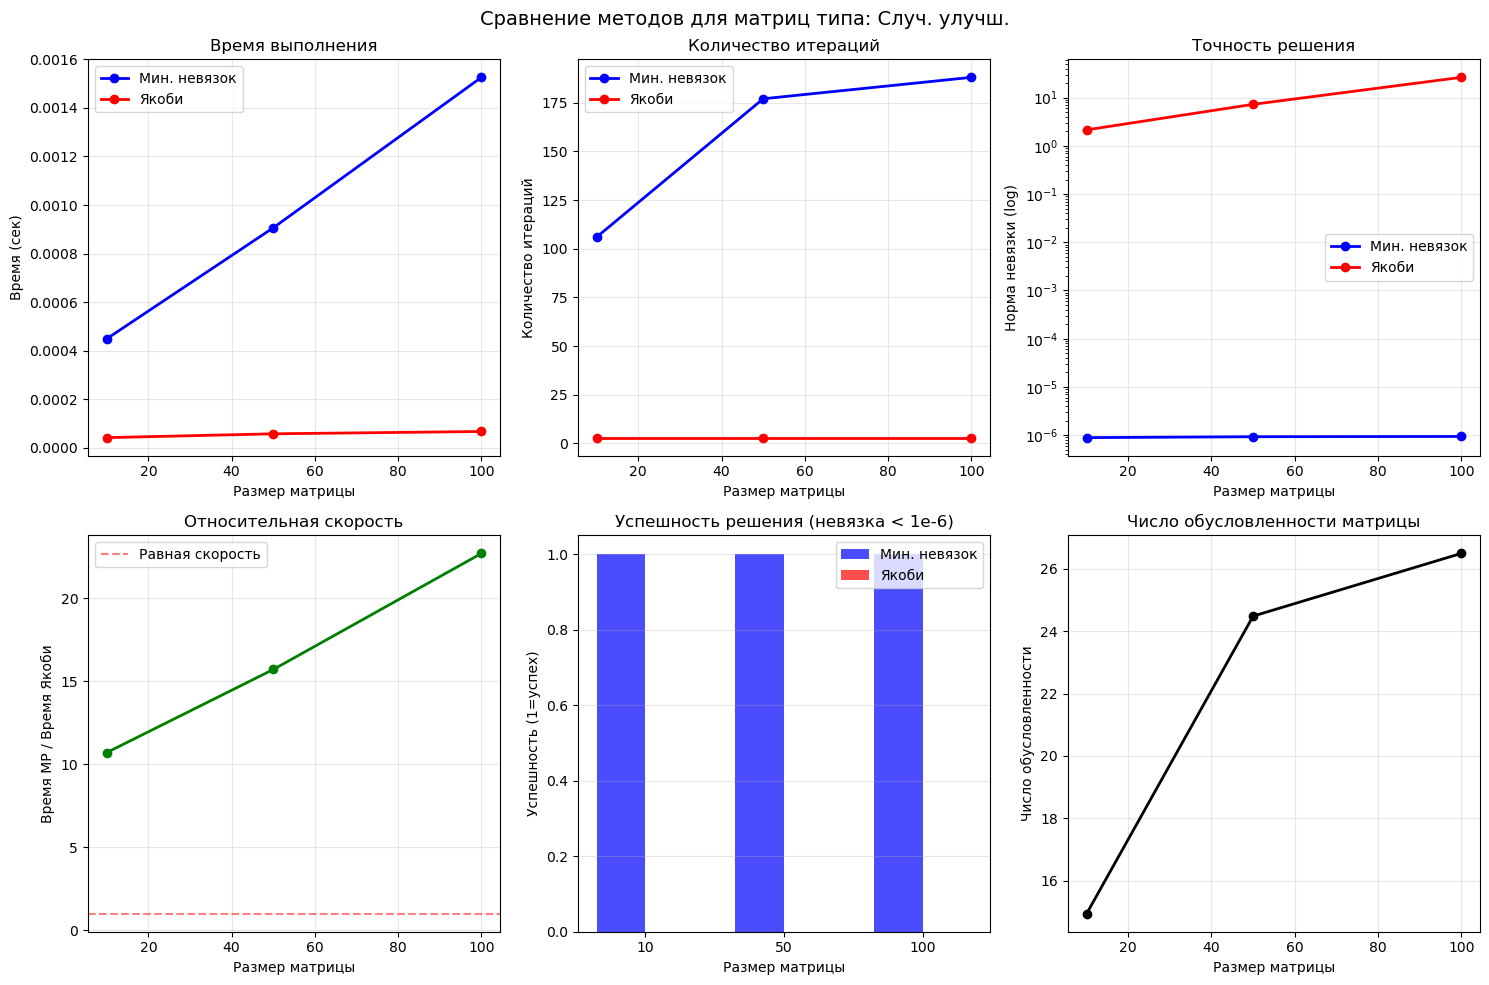

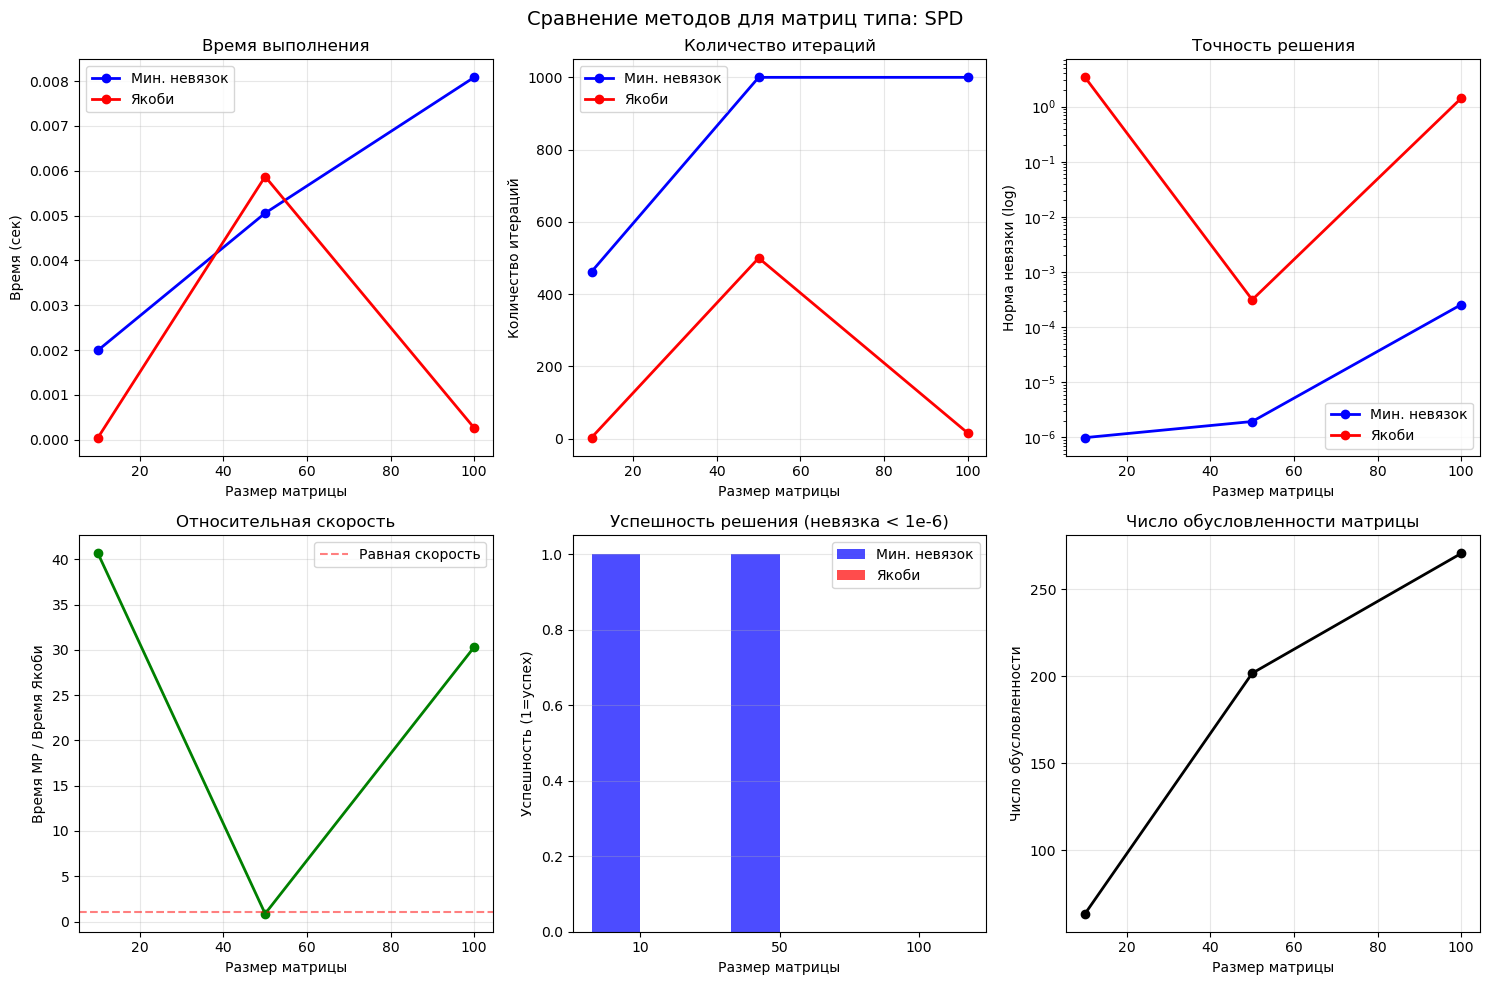

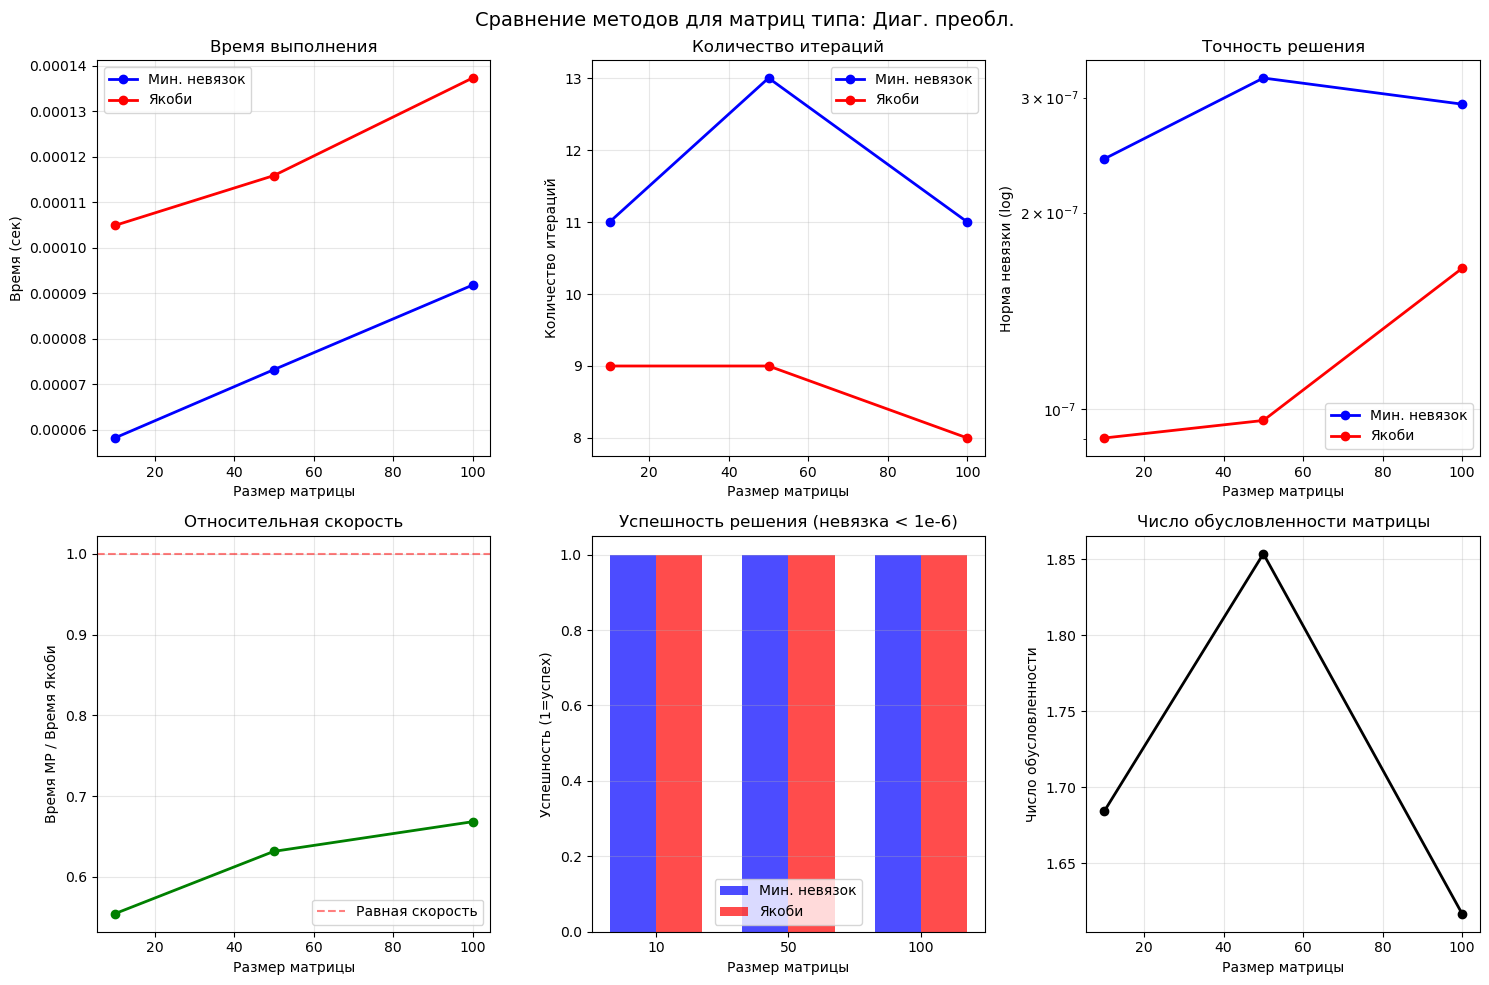


ИТОГОВАЯ СВОДНАЯ ТАБЛИЦА

Размер матрицы: 10x10
----------------------------------------------------------------------
Тип матрицы     Метод                Время (сек)  Итераций   Невязка         Успех 
----------------------------------------------------------------------
Диаг. преобл.   Мин. невязок         0.000058     11         2.42e-07        True  
Диаг. преобл.   Якоби                0.000105     9          9.03e-08        True  

SPD             Мин. невязок         0.001997     462        9.94e-07        True  
SPD             Якоби                0.000049     3          3.40e+00        False 

Случ. улучш.    Мин. невязок         0.000449     106        8.87e-07        True  
Случ. улучш.    Якоби                0.000042     3          2.15e+00        False 


Размер матрицы: 50x50
----------------------------------------------------------------------
Тип матрицы     Метод                Время (сек)  Итераций   Невязка         Успех 
----------------------------------------

In [9]:
print("СРАВНЕНИЕ МЕТОДА МИНИМАЛЬНЫХ НЕВЯЗОК И МЕТОДА ЯКОБИ")
print("="*70)

# Детальный тестовый пример
test_detailed_example()

print("\n" + "="*70)
print("ОСНОВНОЕ СРАВНЕНИЕ НА РАЗНЫХ РАЗМЕРАХ МАТРИЦ")
print("="*70)

try:
    results = compare_iterative_methods()
    
    if results:  # Проверяем, есть ли результаты
        # Визуализация
        plot_results(results)
        
        # Вывод итоговой таблицы
        print("\n" + "="*70)
        print("ИТОГОВАЯ СВОДНАЯ ТАБЛИЦА")
        print("="*70)
        
        # Группируем по размеру матрицы
        sizes = sorted(set(r['n'] for r in results))
        
        for n in sizes:
            print(f"\nРазмер матрицы: {n}x{n}")
            print("-"*70)
            print(f"{'Тип матрицы':<15} {'Метод':<20} {'Время (сек)':<12} {'Итераций':<10} {'Невязка':<15} {'Успех':<6}")
            print("-"*70)
            
            for r in results:
                if r['n'] == n:
                    print(f"{r['matrix_type']:<15} {'Мин. невязок':<20} {r['time_mr']:<12.6f} {r['iter_mr']:<10} {r['residual_mr']:<15.2e} {str(r['success_mr']):<6}")
                    print(f"{r['matrix_type']:<15} {'Якоби':<20} {r['time_jacobi']:<12.6f} {r['iter_jacobi']:<10} {r['residual_jacobi']:<15.2e} {str(r['success_jacobi']):<6}")
                    print()
    else:
        print("Не удалось получить результаты сравнения. Проверьте настройки.")
        
except Exception as e:
    print(f"Ошибка при выполнении сравнения: {e}")
    print("Пробуем с меньшими размерами матриц...")
    
    # Пробуем с совсем маленькими матрицами
    sizes = [3, 5, 10]
    simple_results = []
    
    for n in sizes:
        print(f"\nТестируем размер {n}x{n}")
        
        # Простая матрица с диагональным преобладанием
        A = np.diag(np.ones(n) * (n+1)) + np.ones((n, n)) * 0.1
        b = np.ones(n)
        
        try:
            # Метод минимальных невязок
            start = time.time()
            x_mr, iter_mr, residual_mr = min_residual_method(A, b, eps=1e-6)
            time_mr = time.time() - start
            
            # Метод Якоби
            start = time.time()
            x_jacobi, iter_jacobi, residual_jacobi = jacobi_method(A, b, eps=1e-6)
            time_jacobi = time.time() - start
            
            simple_results.append({
                'n': n,
                'matrix_type': 'Простая',
                'time_mr': time_mr,
                'time_jacobi': time_jacobi,
                'iter_mr': iter_mr,
                'iter_jacobi': iter_jacobi,
                'residual_mr': residual_mr,
                'residual_jacobi': residual_jacobi
            })
            
            print(f"  Мин. невязок: время={time_mr:.6f}, итераций={iter_mr}, невязка={residual_mr:.2e}")
            print(f"  Якоби: время={time_jacobi:.6f}, итераций={iter_jacobi}, невязка={residual_jacobi:.2e}")
            
        except Exception as e2:
            print(f"  Ошибка: {e2}")